# Downloading Datasets

In [1]:
import kagglehub

path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

100%|██████████| 13.7G/13.7G [01:54<00:00, 129MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1


# Running preprocess

In [2]:
!pip install wordcloud scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
!ls /root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/

captions_train2014.json  instances_train2014.json  person_keypoints_train2014.json
captions_val2014.json	 instances_val2014.json    person_keypoints_val2014.json


In [3]:
import json
from pathlib import Path
import spacy
import logging
from datetime import datetime
import pickle
import numpy as np
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# without embedding

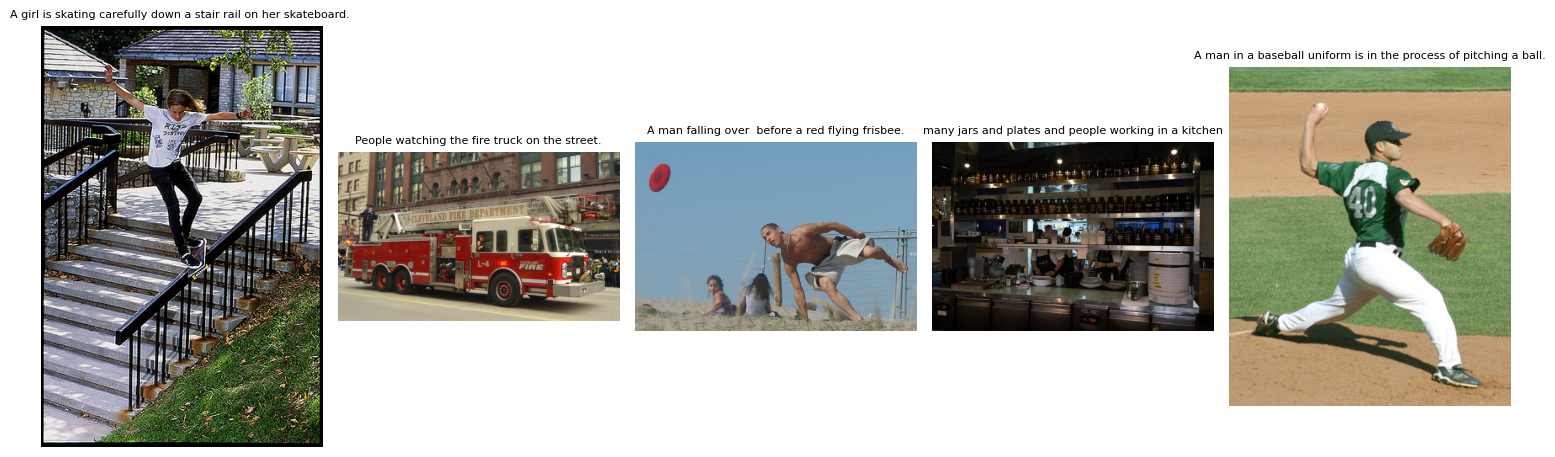


Dataset Demographics Summary:
Total images: 48339

Gender distribution:
male: 14995 (31.02%)
female: 7940 (16.43%)
neutral: 15453 (31.97%)

Age group distribution:
child: 3131 (6.48%)
elderly: 413 (0.85%)
adult: 608 (1.26%)
teen: 89 (0.18%)

Group size distribution:
single: 41146 (85.12%)
pair: 828 (1.71%)
group/crowd: 6365 (13.17%)


In [6]:
class COCOPeopleFilter:
    def __init__(self, root, split='train2014', sampling_rate=0.2):
        self.root = Path(root)
        self.split = split
        self.sampling_rate = sampling_rate

        try:
            self.nlp = spacy.load('en_core_web_sm')
        except:
            logging.info("Installing spaCy model...")
            os.system('python -m spacy download en_core_web_sm')
            self.nlp = spacy.load('en_core_web_sm')

        self.people_keywords = {
            'man', 'woman', 'person', 'boy', 'girl', 'child', 'baby', 'people',
            'group', 'crowd', 'family', 'player', 'worker', 'student', 'kid',
            'children', 'adult', 'teenager', 'lady', 'gentleman', 'human'
        }

    def _is_people_related(self, caption):
        caption_lower = caption.lower()

        if any(keyword in caption_lower for keyword in self.people_keywords):
            return True

        doc = self.nlp(caption)
        if any(ent.label_ in ['PERSON'] for ent in doc.ents):
            return True

        return False

    def _load_image(self, img_path):
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                return img.copy()
        except Exception as e:
            logging.error(f"Error loading image {img_path}: {str(e)}")
            return None

    def analyze_demographics(self, dataset):
        gender_terms = {
            'male': ['man', 'boy', 'gentleman', 'male', 'men', 'boys', 'father', 'dad'],
            'female': ['woman', 'girl', 'lady', 'female', 'women', 'girls', 'mother', 'mom'],
            'neutral': ['person', 'people', 'child', 'children', 'human', 'baby', 'adult', 'teenager']
        }

        gender_counts = {category: 0 for category in gender_terms.keys()}
        age_groups = Counter()
        activities = Counter()
        group_sizes = Counter()

        for item in dataset:
            caption = item['caption'].lower()

            for category, terms in gender_terms.items():
                if any(f" {term} " in f" {caption} " for term in terms):
                    gender_counts[category] += 1

            age_patterns = {
                'child': r'\b(child|kid|baby|toddler)\w*\b',
                'teen': r'\b(teen|adolescent)\w*\b',
                'adult': r'\b(adult|grown[-\s]?up)\w*\b',
                'elderly': r'\b(elderly|senior|old)\s*(person|man|woman|people)?\b'
            }

            for age_group, pattern in age_patterns.items():
                if re.search(pattern, caption):
                    age_groups[age_group] += 1

            if 'group' in caption or 'crowd' in caption:
                group_sizes['group/crowd'] += 1
            elif any(word in caption for word in ['couple', 'pair']):
                group_sizes['pair'] += 1
            else:
                group_sizes['single'] += 1

            activity_patterns = r'\b(playing|walking|sitting|standing|eating|working|running|riding|skiing|surfing)\b'
            activities.update(re.findall(activity_patterns, caption))

        return {
            'gender_distribution': gender_counts,
            'age_groups': dict(age_groups),
            'group_sizes': dict(group_sizes),
            'activities': dict(activities)
        }

    def plot_demographics(self, analysis_results):
        plt.rcParams['figure.figsize'] = [15, 12]
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3

        fig, axes = plt.subplots(2, 3)
        fig.suptitle('COCO Dataset Demographics Analysis', fontsize=16, y=1.02)

        gender_data = pd.Series(analysis_results['gender_distribution'])
        axes[0, 0].bar(gender_data.index, gender_data.values, color=['skyblue', 'pink', 'lightgreen'])
        axes[0, 0].set_title('Gender Distribution in Captions')
        axes[0, 0].set_ylabel('Count')

        age_data = pd.Series(analysis_results['age_groups'])
        axes[0, 1].bar(age_data.index, age_data.values, color='lightblue')
        axes[0, 1].set_title('Age Group Distribution')
        axes[0, 1].set_ylabel('Count')

        group_data = pd.Series(analysis_results['group_sizes'])
        axes[0, 2].bar(group_data.index, group_data.values, color='lightgreen')
        axes[0, 2].set_title('Group Size Distribution')
        axes[0, 2].set_ylabel('Count')

        activity_data = pd.Series(analysis_results['activities']).nlargest(10)
        axes[1, 0].barh(activity_data.index, activity_data.values, color='salmon')
        axes[1, 0].set_title('Top 10 Activities')
        axes[1, 0].set_xlabel('Count')

        # Pie chart for gender distribution
        axes[1, 1].pie(gender_data, labels=gender_data.index, autopct='%1.1f%%', colors=['skyblue', 'pink', 'lightgreen'])
        axes[1, 1].set_title('Gender Distribution (Pie)')

        # Pie chart for group sizes
        axes[1, 2].pie(group_data, labels=group_data.index, autopct='%1.1f%%', colors=['lightcoral', 'gold', 'cyan'])
        axes[1, 2].set_title('Group Sizes (Pie)')

        plt.tight_layout()
        return fig

    def display_sample_images(self, dataset, num_samples=5):
        """Display a sample of images with captions."""
        plt.figure(figsize=(15, 15))
        for i, sample in enumerate(np.random.choice(dataset, size=num_samples, replace=False)):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(sample['image'])
            plt.axis('off')
            plt.title(sample['caption'], fontsize=8)
        plt.tight_layout()
        plt.show()

    def filter_dataset(self):
        logging.info("Loading COCO annotations...")
        ann_file = self.root / 'annotations_trainval2014' / f'annotations/captions_{self.split}.json'

        if not ann_file.exists():
            raise FileNotFoundError(f"Annotations file not found: {ann_file}")

        with open(ann_file, 'r') as f:
            annotations = json.load(f)

        logging.info("Filtering people-related captions...")
        image_captions = {}
        for ann in annotations['annotations']:
            if self._is_people_related(ann['caption']):
                img_id = ann['image_id']
                if img_id not in image_captions:
                    image_captions[img_id] = []
                image_captions[img_id].append(ann['caption'])

        dataset = []
        for img in annotations['images']:
            if img['id'] in image_captions:
                img_path = str(self.root / self.split / self.split / f"{img['file_name']}")
                image = self._load_image(img_path)
                if image is not None:
                    selected_caption = np.random.choice(image_captions[img['id']], size=1)[0]
                    dataset.append({
                        'image_path': img_path,
                        'image': image,
                        'caption': selected_caption
                    })

        logging.info("Analyzing demographic distribution...")
        demographic_analysis = self.analyze_demographics(dataset)

        fig = self.plot_demographics(demographic_analysis)

        output_path = f'coco_people_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
        fig.savefig(f'{output_path}_plots.png', bbox_inches='tight', dpi=300)
        plt.close(fig)

        with open(f'{output_path}_stats.json', 'w') as f:
            json.dump(demographic_analysis, f, indent=4)

        logging.info(f"Analysis results saved to {output_path}_stats.json")
        logging.info(f"Plots saved to {output_path}_plots.png")

        self.display_sample_images(dataset)

        return dataset, demographic_analysis

if __name__ == "__main__":
    try:
        filter = COCOPeopleFilter(
            root="/root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1",
            split="train2014",
            sampling_rate=1
        )

        dataset, analysis = filter.filter_dataset()

        print("\nDataset Demographics Summary:")
        print(f"Total images: {len(dataset)}")
        print("\nGender distribution:")
        for gender, count in analysis['gender_distribution'].items():
            print(f"{gender}: {count} ({count/len(dataset)*100:.2f}%)")

        print("\nAge group distribution:")
        for age, count in analysis['age_groups'].items():
            print(f"{age}: {count} ({count/len(dataset)*100:.2f}%)")

        print("\nGroup size distribution:")
        for size, count in analysis['group_sizes'].items():
            print(f"{size}: {count} ({count/len(dataset)*100:.2f}%)")

    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
